In [1]:
!nvidia-smi

Sat Jul 13 08:47:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:21:00.0 Off |                  N/A |
| 66%   79C    P2             248W / 250W |   4279MiB / 11264MiB |     97%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!nvidia-smi | grep '/vol/bitbucket/ms922/myenv/bin/python' | awk '{ print $5 }' | xargs -n1 kill -9


Usage:
 kill [options] <pid> [...]

Options:
 <pid> [...]            send signal to every <pid> listed
 -<signal>, -s, --signal <signal>
                        specify the <signal> to be sent
 -q, --queue <value>    integer value to be sent with the signal
 -l, --list=[<signal>]  list all signal names, or convert one to a name
 -L, --table            list all signal names in a nice table

 -h, --help     display this help, and exit
 -V, --version  output version information, and exit

For more details, see kill(1).


In [3]:
%run ./00_header.ipynb

/tmp/ipykernel_3727190/168946515.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
parser = add_shared_args()

parser.add_argument('--lr_teacher', type=float, default=0.01, help='learning rate for updating network parameters')
parser.add_argument('--batch_syn', type=int, default=None, help='batch size for syn data')
parser.add_argument('--buffer_path', type=str, default='./buffers', help='buffer path')
parser.add_argument('--load_all', action='store_true')
parser.add_argument('--max_start_epoch', type=int, default=5)
parser.add_argument('--max_files', type=int, default=None)
parser.add_argument('--max_experts', type=int, default=None)
parser.add_argument('--expert_epochs', type=int, default=3, help='how many expert epochs the target params are')
parser.add_argument('--syn_steps', type=int, default=20, help='how many steps to take on synthetic data')

parser.add_argument('--lr_img', type=float, default=1, help='learning rate for pixels or f_latents')
parser.add_argument('--lr_w', type=float, default=0.001, help='learning rate for updating synthetic latent w')
parser.add_argument('--lr_lr', type=float, default=1e-06, help='learning rate learning rate')
parser.add_argument('--lr_g', type=float, default=0.1, help='learning rate for gan weights')

parser.add_argument('--lr_net', type=float, default=0.01, help='learning rate for updating network parameters')
parser.add_argument('--inner_loop', type=int, default=1, help='inner loop')
parser.add_argument('--outer_loop', type=int, default=1, help='outer loop')
parser.add_argument('--dis_metric', type=str, default='ours', help='distance metric')
parser_bool(parser, 'net_decay', False)
# parser_bool(parser, 'aug', False)
args = parser.parse_args([])

In [5]:
args.num_eval = 5
args.dataset = "ultrasound"
args.ipc = 50
args.space = "p"
args.eval_it = 100
args.method = "idm"
args.depth = 4
args.res = 64
args.nz = 100
args.epoch_eval_train = 100

args.Iteration = 1000

args.use_gan = True
args.per_video = False
args.add_variance = False
args.init_beta_dist = False

args.net_num = 10
args.fetch_net_num = 2
args.train_net_num = 2
args.net_generate_interval = 30
args.net_begin = 0
args.net_end = 100000
args.mismatch_type = "l1"
args.ij_selection = "random"
args.aug_num = 1
args.outer_loop = 1
args.inner_loop = 1
args.syn_ce = False
args.model_train_steps = 10
args.trained_bs = 256
args.aug = False
args.ce_weight = 0.1

if args.syn_ce:
    args.method += "_ce"

args.sample_ratio = 0.01

args.use_sample_ratio = bool(args.sample_ratio is not None or args.sample_ratio > 0)

args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.dsa_param = ParamDiffAug()
args.dsa = False if args.dsa_strategy in ['none', 'None'] else True

In [6]:
eval_it_pool = np.arange(0, args.Iteration + 1, args.eval_it).tolist()
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader, loader_train_dict, class_map, class_map_inv = get_dataset(
    args.dataset, args.data_path, args.batch_real, args.res, args=args)

model_eval_pool = get_eval_pool(args.eval_mode, args.model, args.model)

accs_all_exps = dict() # record performances of all experiments
for key in model_eval_pool:
    accs_all_exps[key] = []

data_save = []
args.distributed = torch.cuda.device_count() > 1

In [7]:
if args.use_gan:
    dataset_dict_path = f'dataset_dict_{args.dataset}_gan.pkl'
else:
    dataset_dict_path = f'dataset_dict_{args.dataset}.pkl'

print(dataset_dict_path)

if os.path.exists(dataset_dict_path):
    with open(dataset_dict_path, 'rb') as file:
        images_all, labels_all, indices_class = pickle.load(file)
else:
    images_all, labels_all, indices_class = build_dataset(dst_train, class_map, num_classes)
    dataset_dict = images_all, labels_all, indices_class
    with open(dataset_dict_path, 'wb') as pickle_file:
        pickle.dump(dataset_dict, pickle_file)

dataset_dict_ultrasound_gan.pkl


In [8]:
if args.use_sample_ratio:
    n_sample_list = get_sample_syn_label(labels_all, args.sample_ratio, min_syn=15, max_syn=200)
    print(sum(n_sample_list))
    print(n_sample_list)

618
[ 27  28  43 200  48  71  40  18  43  29  15  26  15  15]


In [9]:
G, zdim = None, None

In [10]:
if args.use_gan:
    mean_tensor = torch.Tensor([0.5])
    std_tensor = torch.Tensor([0.5])
else:
    mean_tensor = torch.Tensor(mean)
    std_tensor = torch.Tensor(std)
unnormalize = transforms.Normalize((-mean_tensor / std_tensor).tolist(), (1.0 / std_tensor).tolist())

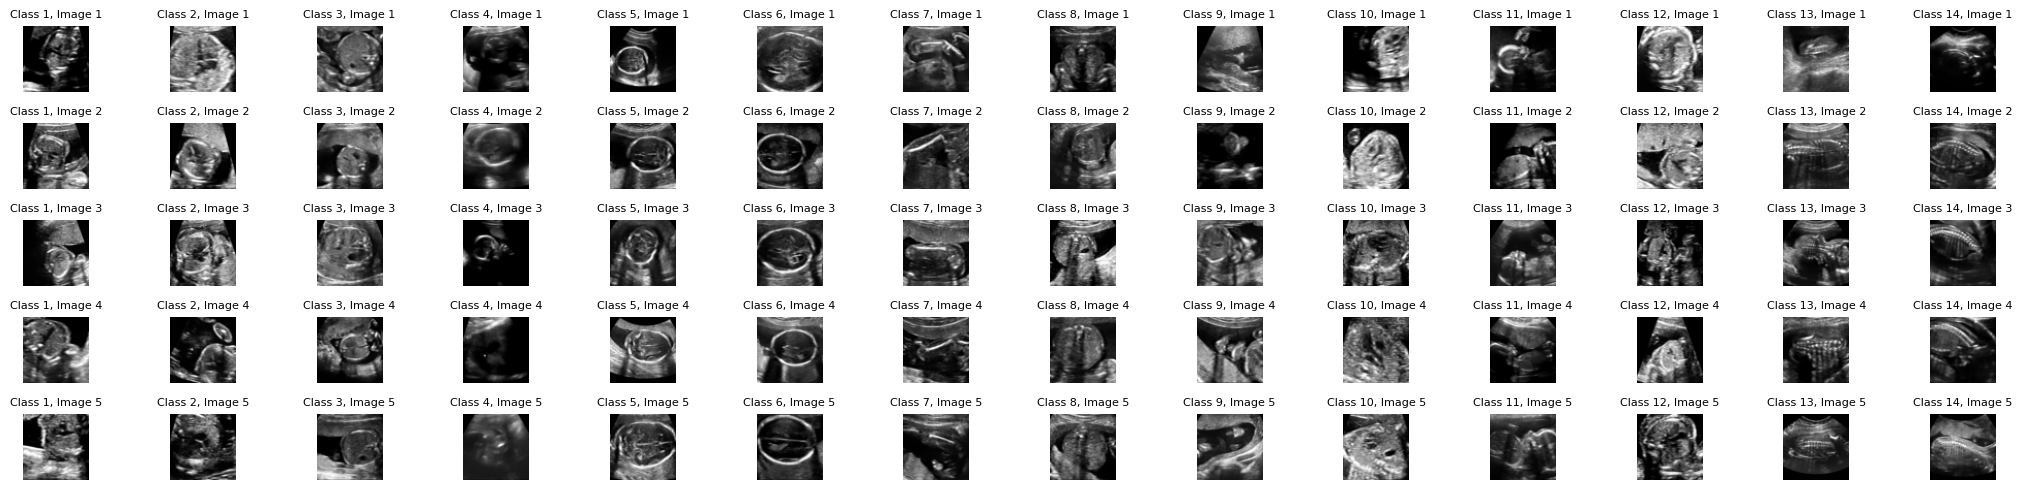

In [11]:
n_img = 5

real_img_tmp_list = [get_images(c, n_img) for c in range(num_classes)]
real_img_tmp_tensor = torch.cat(real_img_tmp_list)
display_latent(real_img_tmp_tensor, num_classes, n_img, True)

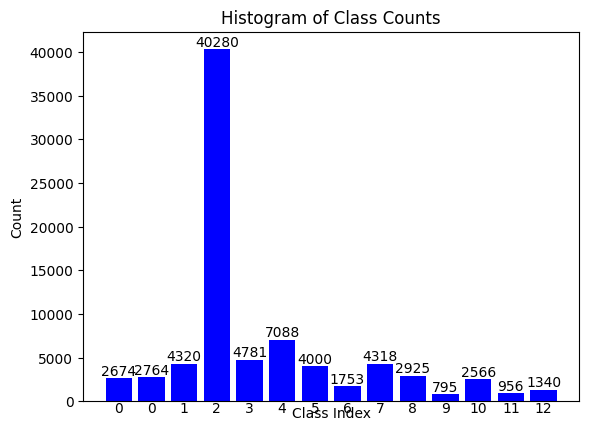

In [12]:
unique, counts = np.unique(labels_all.numpy(), return_counts=True)
dist = list(zip(unique, counts))
class_indices = [pair[0] for pair in dist]
counts = [pair[1] for pair in dist]

# Plot the histogram
bars = plt.bar(class_indices, counts, color='blue')

# Add labels and title
plt.xlabel('Class Index')
plt.ylabel('Count')
plt.title('Histogram of Class Counts')
plt.xticks([])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, -10, str(int(bar.get_x())), ha='center', va='top')
plt.show()


In [13]:
test_class_count = count_classes(testloader)
test_class_count = list(dict(sorted(test_class_count.items())).values())

100%|██████████| 299/299 [00:28<00:00, 10.50it/s]


# Training All

In [ ]:
torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

args.epoch_eval_train = 50

res_dict = {}

model_eval_list = ["ConvNet", "ResNet18", "AlexNet", "VGG11", "ViT"]
# model_eval_list = ["ConvNet"]
eval_pool_dict = get_eval_lrs(args)
for model_eval in model_eval_list:
    # if model_eval == "ConvNet":
    #     continue
    print(f"model: {model_eval}")
    args.lr_net = eval_pool_dict[model_eval]
    metric_train_all = []
    metric_test_all = []
    for it_eval in range(args.num_eval):
        torch.cuda.empty_cache()
        gc.collect()
        net = get_network(model_eval, channel, num_classes, im_size, depth=args.depth, width=args.width).to(args.device) # get a random model
        net.train()
        _, metric_train_list, metric_test_list = evaluate_synset(it_eval, net, images_all, labels_all, testloader, args, decay="cosine", aug=True)
        metric_train_all.append(metric_train_list)
        metric_test_all.append(metric_test_list)
    res_dict[model_eval] = metric_test_all

model: ConvNet


  2%|▏         | 1/50 [00:20<16:24, 20.10s/it]

In [ ]:
dir = "../experiment_res/full_dataset"
save_res_dict_excel(res_dict, test_class_count, dir, file_prefix="full_dataset_")

NameError: name 'res_dict' is not defined

# Training Random Image subset

In [93]:
torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

args.epoch_eval_train = 500

model_eval_list = ["ConvNet", "ResNet18", "VGG11", "ViT"]
# model_eval_list = ["ViT"]

res_random_dict = {}

eval_pool_dict = get_eval_lrs(args)
for model_eval in model_eval_list:
    args.lr_net = eval_pool_dict[model_eval]
    print(f"model: {model_eval}")
    metric_train_all = []
    metric_test_all = []
    for it_eval in range(args.num_eval):
        torch.cuda.empty_cache()
        gc.collect()
        if args.per_video:
            random_image_list = torch.cat([get_images_per_video(c, args.ipc) for c in video_id_list])
            random_label_list = torch.tensor([int(c.split("__")[1]) for c in video_id_list for _ in range(args.ipc)])
        else:
            random_image_list = torch.cat([get_images(c, args.ipc) for c in range(num_classes)])
            random_label_list = torch.tensor([label for label in range(num_classes) for _ in range(args.ipc)])
        net = get_network(model_eval, channel, num_classes, im_size, depth=args.depth, width=args.width).to(args.device) 
        net.train()
        _, metric_train_list, metric_test_list = evaluate_synset(
            it_eval, net, random_image_list, random_label_list, testloader, args, decay="cosine", aug=True
        )
        metric_train_all.append(metric_train_list)
        metric_test_all.append(metric_test_list)
    
    res_random_dict[model_eval] = metric_test_all

model: ViT


100%|██████████| 500/500 [01:15<00:00,  6.59it/s]


In [94]:
dir = "../experiment_res/random"
save_res_dict_excel(res_random_dict, test_class_count, dir, file_prefix="random_")

Accuracy avg:0.110321, std:0.019494


# Random with Ratio

In [35]:
torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

args.epoch_eval_train = 500

model_eval_list = ["ConvNet"]
# model_eval_list = ["ViT"]

res_random_dict = {}

eval_pool_dict = get_eval_lrs(args)
for model_eval in model_eval_list:
    args.lr_net = eval_pool_dict[model_eval]
    print(f"model: {model_eval}")
    metric_train_all = []
    metric_test_all = []
    for it_eval in range(args.num_eval):
        torch.cuda.empty_cache()
        gc.collect()
        random_image_list = torch.cat([get_images(c, n_sample_list[c]) for c in range(num_classes)])
        random_label_list = torch.tensor([i for i in range(num_classes) for _ in range(n_sample_list[i])])
        net = get_network(model_eval, channel, num_classes, im_size, depth=args.depth, width=args.width).to(args.device) 
        net.train()
        _, metric_train_list, metric_test_list = evaluate_synset(
            it_eval, net, random_image_list, random_label_list, testloader, args, decay="cosine", aug=True
        )
        metric_train_all.append(metric_train_list)
        metric_test_all.append(metric_test_list)
    
    res_random_dict[model_eval] = metric_test_all

model: ConvNet


100%|██████████| 500/500 [03:02<00:00,  2.74it/s]


In [36]:
if args.use_sample_ratio:
    save_name = f'random_sample_{str(args.sample_ratio).replace(".", "__")}_'
else:
    save_name = f"random_sample_{args.ipc}_"

dir = "../experiment_res/random"
save_res_dict_excel(res_random_dict, test_class_count, dir, file_prefix=save_name)

Accuracy avg:0.724467, std:0.015682


# Load Pretrained GAN

/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


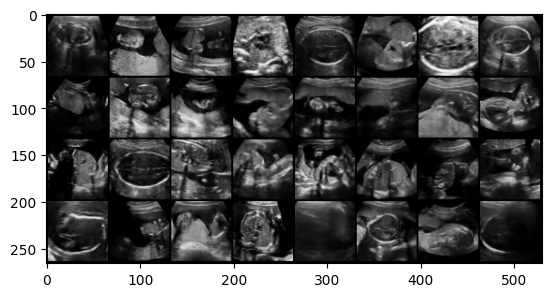

In [15]:
if args.use_gan:

    nz = 100  # Size of z latent vector (i.e., generator input)
    ngf = 64  # Size of feature maps in generator
    ndf = 64  # Size of feature maps in discriminator
    nc = 1    # Number of channels in the training images

    generator = Generator(nz, ngf, nc).to(args.device)
    generator.load_state_dict(torch.load("../gan/models/net_G_relu_64_video_net_new_epoch_49.pth"))

    generator = generator.eval()
    for param in generator.parameters():
        param.requires_grad = False
    fixed_noise = torch.randn(32, args.nz, 1, 1, device=args.device)
    with torch.no_grad():
        fake = generator(fixed_noise)
    show(make_grid(denorm(fake), nrow=8, padding=2, normalize=False, value_range=None, scale_each=False, pad_value=0))

# Training IDM

In [17]:
run = wandb.init(
    project="GLaD",
    job_type=args.method.upper(),
    config=args
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jack47744. Use `wandb login --relogin` to force relogin


In [18]:
if args.use_sample_ratio:
    print(f"Sample with ratio of {args.sample_ratio}")
    latents, f_latents, label_syn = get_latent_sample(n_sample_list, args)
else:
    print(f"Sample with number of {args.ipc}")
    latents, f_latents, label_syn = get_latent_ipc(args)

print(latents.shape)

Sample with ratio of 0.01
torch.Size([618, 100, 1, 1])


In [19]:
torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

optimizer_img = get_img_optimizer(latents, args)

net_num = args.net_num
net_list = list()
optimizer_list = list()
acc_meters = list()

for net_index in range(3):
    net = get_network(args.model, channel, num_classes, im_size, depth=args.depth, width=args.width).to(args.device)
    net.train()
    if args.net_decay:
        optimizer_net = torch.optim.SGD(net.parameters(), lr=args.lr_net, momentum=0.9, weight_decay=0.0005)
    else:
        optimizer_net = torch.optim.SGD(net.parameters(), lr=args.lr_net)  # optimizer_img for synthetic data
    optimizer_net.zero_grad()
    net_list.append(net)
    optimizer_list.append(optimizer_net)
    acc_meters.append(torchnet.meter.ClassErrorMeter(accuracy=True))

criterion = nn.CrossEntropyLoss().to(args.device)


for it in tqdm(range(args.Iteration+1), desc="Training Iterations"):

    if it % args.net_generate_interval == 0:
        # append and pop net list:
        if len(net_list) == net_num:
            net_list.pop(0)
            optimizer_list.pop(0)
            acc_meters.pop(0)
        net = get_network(args.model, channel, num_classes, im_size, depth=args.depth, width=args.width).to(args.device) # get a random model
        net.train()
        if args.net_decay:
            optimizer_net = torch.optim.SGD(net.parameters(), lr=args.lr_net, momentum=0.9, weight_decay=0.0005)
        else:
            optimizer_net = torch.optim.SGD(net.parameters(), lr=args.lr_net)  # optimizer_img for synthetic data
        optimizer_net.zero_grad()
        net_list.append(net)
        optimizer_list.append(optimizer_net)
        acc_meters.append(torchnet.meter.ClassErrorMeter(accuracy=True))

    _ = list(range(len(net_list)))
    if len(_[args.net_begin: args.net_end]) > 10:
        _ = _[args.net_begin: args.net_end]
    random.shuffle(_)
    if args.ij_selection == 'random':
        # net_index_i, net_index_j = _[:2]
        net_index_list = _[:args.train_net_num]
    else:
        raise NotImplemented()
    train_net_list = [net_list[ind] for ind in net_index_list]
    train_acc_list = [acc_meters[ind] for ind in net_index_list]

    embed_list = [net.module.embed if torch.cuda.device_count() > 1 else net.embed for net in train_net_list]

    for _ in range(args.outer_loop):
        loss_avg = 0
        mtt_loss_avg = 0
        metrics = {'syn': 0, 'real': 0}
        acc_avg = {'syn':torchnet.meter.ClassErrorMeter(accuracy=True)}

        if args.use_gan:
            with torch.no_grad():
                image_syn_w_grad = generator(latents)
        else:
            image_syn_w_grad = latents

        if args.use_gan:
            image_syn = image_syn_w_grad.detach()
            image_syn.requires_grad_(True)
        else:
            image_syn = image_syn_w_grad

        ''' update synthetic data '''
        if 'BN' not in args.model or args.model=='ConvNet_GBN': # for ConvNet
            for image_sign, image_temp in [['syn', image_syn]]:
                loss = torch.tensor(0.0).to(args.device)
                for net_ind in range(len(train_net_list)):
                    # print(net_ind)
                    net = train_net_list[net_ind]
                    net.eval()
                    embed = embed_list[net_ind]
                    net_acc = train_acc_list[net_ind]
                    for c in range(num_classes):
                        # print(f"Class: {c}")
                        loss_c = torch.tensor(0.0).to(args.device)
                        img_real = get_images(c, args.batch_real)
                        # img_syn = image_temp[c*args.ipc:(c+1)*args.ipc].reshape((args.ipc, channel, im_size[0], im_size[1]))
                        # lab_syn = label_syn[c*args.ipc:(c+1)*args.ipc]
                        if args.use_sample_ratio:
                            img_syn = get_latent_sample_class(c, image_syn, n_sample_list).reshape((n_sample_list[c], channel, im_size[0], im_size[1]))
                        else:
                            img_syn = image_syn[c*args.ipc:(c+1)*args.ipc].reshape((args.ipc, channel, im_size[0], im_size[1]))
                        lab_syn = torch.ones((img_syn.shape[0],), device=args.device, dtype=torch.long) * c
                        assert args.aug_num == 1

                        if args.aug:
                            img_syn, lab_syn = number_sign_augment(img_syn, lab_syn)

                        if args.dsa:
                            img_real_list = list()
                            img_syn_list = list()
                            for aug_i in range(args.aug_num):
                                seed = int(time.time() * 1000) % 100000
                                img_real_list.append(DiffAugment(img_real, args.dsa_strategy, seed=seed, param=args.dsa_param))
                                img_syn_list.append(DiffAugment(img_syn, args.dsa_strategy, seed=seed, param=args.dsa_param))
                            img_real = torch.cat(img_real_list)
                            img_syn = torch.cat(img_syn_list)

                        # output_real = embed(img_real, last=args.embed_last).detach()
                        # output_syn = embed(img_syn, last=args.embed_last)
                        output_real = embed(img_real).detach()
                        output_syn = embed(img_syn)

                        loss_c += torch.sum((torch.mean(output_real, dim=0) - torch.mean(output_syn, dim=0))**2)
                        # print(img_syn.shape)
                        logits_syn = net(img_syn)
                        metrics[image_sign] += F.cross_entropy(logits_syn, lab_syn.repeat(args.aug_num)).detach().item()
                        acc_avg[image_sign].add(logits_syn.detach(), lab_syn.repeat(args.aug_num))

                        syn_ce_loss = 0
                        if args.syn_ce:
                            weight_i = net_acc.value()[0] if net_acc.n != 0 else 0
                            syn_ce_loss += (F.cross_entropy(logits_syn, lab_syn.repeat(args.aug_num)) * weight_i)

                            loss_c += (syn_ce_loss * args.ce_weight)

                        optimizer_img.zero_grad()
                        loss_c.backward()

                        if args.use_gan:
                            # this method works in-line and back-props gradients to latents and f_latents
                            # gan_backward(latents=latents, f_latents=f_latents, image_syn=image_syn, G=G, args=args)
                            latents_detached = latents.detach().clone().requires_grad_(True)
                            syn_images = generator(latents_detached)
                            syn_images.backward((image_syn.grad,))
                            latents.grad = latents_detached.grad

                        else:
                            latents.grad = image_syn.grad.detach().clone()

                        optimizer_img.step()
                        loss += loss_c.item()

                        del output_real, output_syn, loss_c 
                        torch.cuda.empty_cache()
                        gc.collect()

                    del net, embed
                    torch.cuda.empty_cache()
                    gc.collect()

                if image_sign == 'syn':
                    loss_avg += loss.item()
        else:
            raise NotImplemented()

        loss_avg /= (num_classes)
        mtt_loss_avg /= (num_classes)
        metrics = {k:v/num_classes for k, v in metrics.items()}

        wandb.log({
            "Loss": loss_avg
        }, step=it)

        shuffled_net_index = list(range(len(net_list)))
        random.shuffle(shuffled_net_index)
        for j in range(min(args.fetch_net_num, len(shuffled_net_index))):
            training_net_idx = shuffled_net_index[j]
            net_train = net_list[training_net_idx]
            net_train.train()
            optimizer_net_train = optimizer_list[training_net_idx]
            acc_meter_net_train = acc_meters[training_net_idx]
            for i in range(args.model_train_steps):
                img_real_, lab_real_ = get_images(c=None, n=args.trained_bs)
                real_logit = net_train(img_real_)
                syn_cls_loss = criterion(real_logit, lab_real_)
                optimizer_net_train.zero_grad()
                syn_cls_loss.backward()
                optimizer_net_train.step()
                acc_meter_net_train.add(real_logit.detach(), lab_real_)

        if it % 20 == 0:
            with torch.no_grad():
                
                sample_path = f"./{args.method}_samples/{args.dataset}" if args.use_gan else f"./{args.method}_samples/{args.dataset}_no_gan"

                if not os.path.exists(sample_path):
                    os.makedirs(sample_path)

                save_img_path = f"{sample_path}/fake_{it:04d}.png" if not args.add_variance else f"{sample_path}/var_fake_{it:04d}.png"
                if args.use_gan:
                    save_image(denorm(syn_images.cpu()).float(), save_img_path)
                else:
                    save_image(denorm(latents.cpu()).float(), save_img_path)

        # if it == args.Iteration: # only record the final results
        if it % 50 == 0 and it > 0:
            data_save.append([copy.deepcopy(image_syn.detach().cpu()), copy.deepcopy(label_syn.detach().cpu())])

            if args.use_gan:
                with torch.no_grad():
                    save_latent = generator(latents)
            else:
                save_latent = latents

            latent_path = f"./{args.method}_latents/{args.dataset}" if args.use_gan else f"./{args.method}_latents/{args.dataset}_no_gan"

            if not os.path.exists(latent_path):
                os.makedirs(latent_path)

            if args.use_sample_ratio:
                save_latent_path =  f'{latent_path}/{str(args.sample_ratio).replace(".", "__")}_ori_{it:04d}.pt' if not args.add_variance else f'{latent_path}/var_{str(args.sample_ratio).replace(".", "__")}_ori_{it:04d}.pt'
            else:
                save_latent_path =  f'{latent_path}/{args.ipc}_ori_{it:04d}.pt' if not args.add_variance else f'{latent_path}/var_{args.ipc}_ori_{it:04d}.pt'
            torch.save(save_latent, save_latent_path)
            print(f"Save at {save_latent_path}")

    # if it%10 == 0:
    #     print('%s iter = %04d, loss = syn:%.4f, net_list size = %s, metrics = syn:%.4f/real:%.4f, syn acc = syn:%.4f' % (get_time(), it, \
    #         loss_avg, str(len(net_list)), metrics['syn'], metrics['real'], acc_avg['syn'].value()[0] if acc_avg['syn'].n!=0 else 0))

    # if it == args.Iteration: # only record the final results
    #     data_save.append([copy.deepcopy(image_syn.detach().cpu()), copy.deepcopy(label_syn.detach().cpu())])
    #     torch.save({'data': data_save, 'accs_all_exps': accs_all_exps, }, os.path.join(args.save_path, 'res_%s_%s_%s_%dipc.pt'%(args.method, args.dataset, args.model, args.ipc)))



Training Iterations:   0%|          | 4/1001 [01:06<4:34:14, 16.50s/it]/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training Iterations:   5%|▌         | 51/1001 [14:03<4:23:23, 16.63s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0050.pt


Training Iterations:  10%|█         | 101/1001 [27:52<4:13:42, 16.91s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0100.pt


Training Iterations:  15%|█▌        | 151/1001 [40:44<3:37:41, 15.37s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0150.pt


Training Iterations:  20%|██        | 201/1001 [53:30<3:28:50, 15.66s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0200.pt


Training Iterations:  25%|██▌       | 251/1001 [1:06:22<3:14:11, 15.53s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0250.pt


Training Iterations:  30%|███       | 301/1001 [1:19:15<3:05:21, 15.89s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0300.pt


Training Iterations:  35%|███▌      | 351/1001 [1:32:15<2:50:57, 15.78s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0350.pt


Training Iterations:  40%|████      | 401/1001 [1:44:21<2:24:38, 14.46s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0400.pt


Training Iterations:  45%|████▌     | 451/1001 [1:56:15<2:10:44, 14.26s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0450.pt


Training Iterations:  50%|█████     | 501/1001 [2:08:10<2:00:32, 14.46s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0500.pt


Training Iterations:  55%|█████▌    | 551/1001 [2:20:04<1:47:22, 14.32s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0550.pt


Training Iterations:  60%|██████    | 601/1001 [2:31:59<1:37:00, 14.55s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0600.pt


Training Iterations:  65%|██████▌   | 651/1001 [2:43:54<1:23:17, 14.28s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0650.pt


Training Iterations:  70%|███████   | 701/1001 [2:55:47<1:12:24, 14.48s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0700.pt


Training Iterations:  75%|███████▌  | 751/1001 [3:07:39<59:28, 14.27s/it]  

Save at ./idm_latents/ultrasound/0__01_ori_0750.pt


Training Iterations:  80%|████████  | 801/1001 [3:19:32<48:18, 14.49s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0800.pt


Training Iterations:  85%|████████▌ | 851/1001 [3:31:23<35:38, 14.26s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0850.pt


Training Iterations:  90%|█████████ | 901/1001 [3:43:15<24:04, 14.45s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0900.pt


Training Iterations:  95%|█████████▌| 951/1001 [3:55:08<11:52, 14.26s/it]

Save at ./idm_latents/ultrasound/0__01_ori_0950.pt


Training Iterations: 100%|██████████| 1001/1001 [4:07:04<00:00, 14.81s/it]

Save at ./idm_latents/ultrasound/0__01_ori_1000.pt


In [21]:
# latent_dir = f"./dc_latents/{args.dataset}" if args.use_gan else f"./dc_latents/{args.dataset}_no_gan"
# latent_path = os.path.join(latent_dir, f"{args.ipc}_ori_0490.pt")
# print(latent_path)
# latents_tmp = torch.load(latent_path, map_location=args.device, weights_only=True)
# latents_tmp = latents_tmp.view(num_classes, args.ipc, channel, im_size[0], im_size[1])


latent_dir = f"./{args.method}_latents/{args.dataset}" if args.use_gan else f"./{args.method}_latents/{args.dataset}_no_gan"
if args.use_sample_ratio:
    save_name = f'{str(args.sample_ratio).replace(".", "__")}_ori_1000.pt'
else:
    save_name = f"{args.ipc}_ori_1000.pt"
latent_path = os.path.join(latent_dir, save_name)
latents_tmp = torch.load(latent_path, map_location=args.device, weights_only=True)
# latents_tmp = latents_tmp.view(num_classes, args.ipc, channel, im_size[0], im_size[1])
print(latent_path)

./idm_latents/ultrasound/0__01_ori_1000.pt


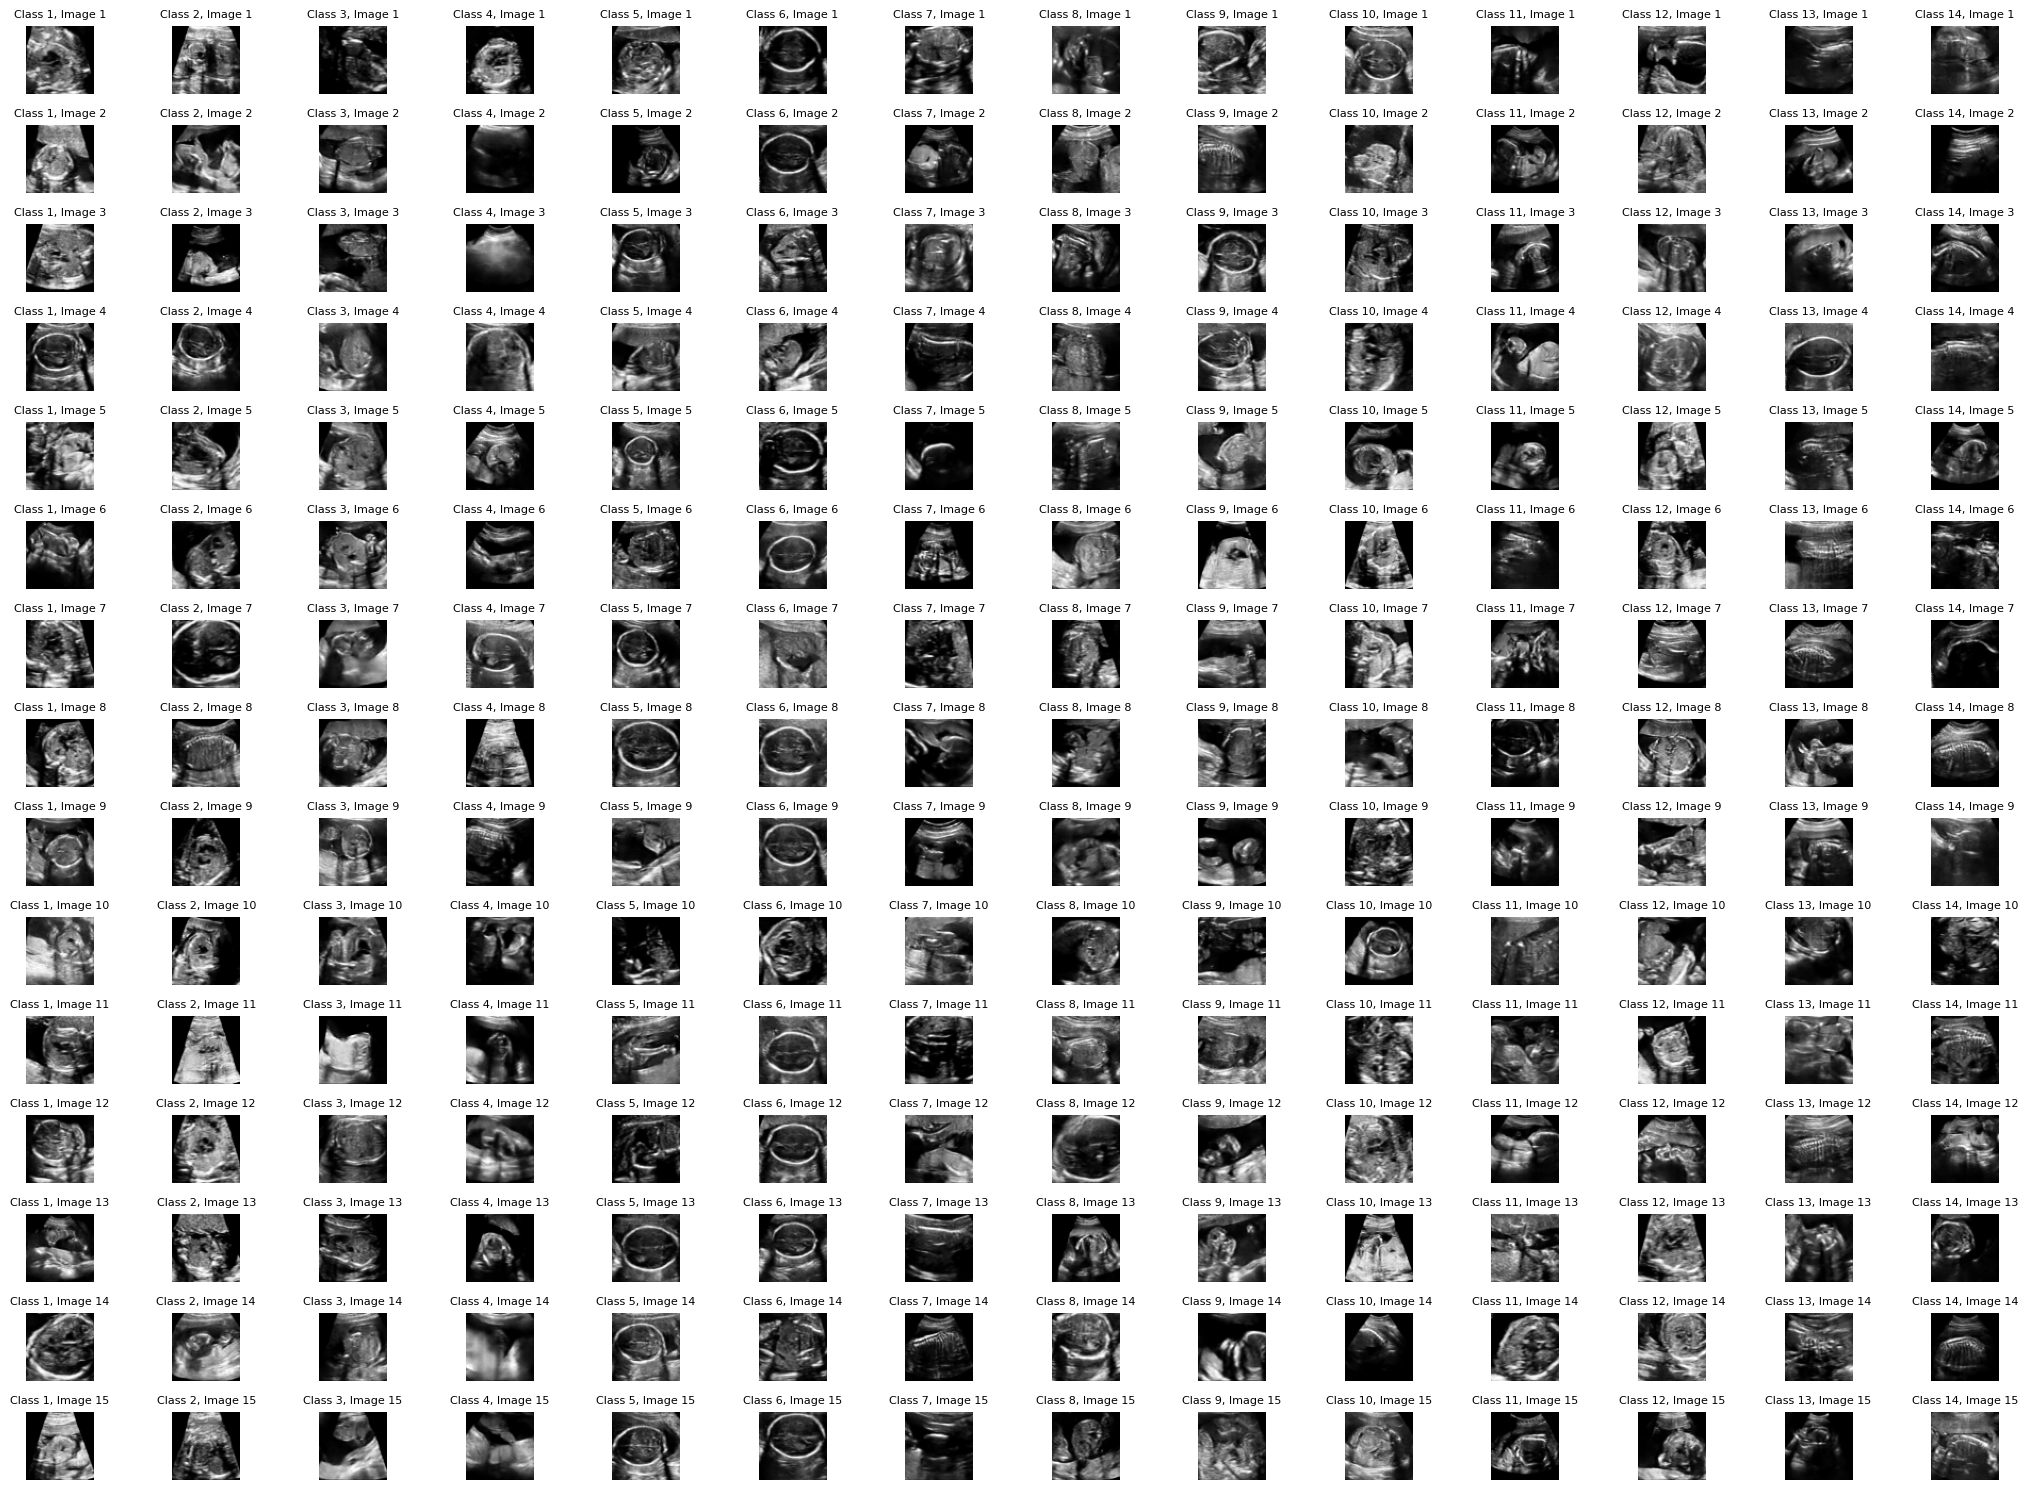

In [22]:
if args.use_sample_ratio:
    sampled_tensors = sample_tensors(latents_tmp, n_sample_list, min(n_sample_list))
    display_latent(sampled_tensors, num_classes, min(n_sample_list), True)
else:
    display_latent(latents_tmp, num_classes, args.ipc, True)

In [23]:
args.epoch_eval_train = 500

model_eval_pool = ["ConvNet"]
latents = latents_tmp.reshape(-1, channel, im_size[0], im_size[1])
if args.use_sample_ratio:
    label_syn = torch.tensor([i for i in range(num_classes) for _ in range(n_sample_list[i])], dtype=torch.long, requires_grad=False, device=args.device).view(-1)
else:
    label_syn = torch.tensor([i*np.ones(args.ipc, dtype=np.int64) for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=args.device).view(-1)
res_dict = eval_loop_v2(latents=latents, f_latents=None, label_syn=label_syn, G=None, best_acc=None,
                best_std=None, testloader=testloader,
                model_eval_pool=model_eval_pool, channel=channel, num_classes=num_classes,
                im_size=im_size, it=0, args=args)

-------------------------
Evaluation
model_train = ConvNet, model_eval = ConvNet, iteration = 0


  0%|          | 0/500 [00:00<?, ?it/s]/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 500/500 [02:59<00:00,  2.79it/s]
/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 500/500 [03:01<00:00,  2.75it/s]


In [24]:
dir = f"../experiment_res/{args.method}_latent_gen" if args.use_gan else f"../experiment_res/{args.method}_latent_gen_no_gan"
if args.use_sample_ratio:
    file_prefix = f'latent_gen_{args.method}_{str(args.sample_ratio).replace(".", "__")}_'  if args.use_gan else f'latent_gen_{args.method}_no_gan_{str(args.sample_ratio).replace(".", "__")}_'
else:
    file_prefix = f"latent_gen_{args.method}_"  if args.use_gan else f"latent_gen_{args.method}_no_gan_"
    
save_res_dict_excel(res_dict, test_class_count, dir, file_prefix=file_prefix)

Accuracy avg:0.726188, std:0.004282


In [25]:
if args.use_sample_ratio:
    tensor_split = split_tensor_to_list(latents_tmp, n_sample_list)
    print([t.shape for t in tensor_split])  # Should print shapes of split tensors
    mse_latent_dict, latent_embed_mean_list = get_most_similar_img(tensor_split, is_stack=False)
else:
    mse_latent_dict, latent_embed_mean_list = get_most_similar_img(latents_tmp)

[torch.Size([27, 1, 64, 64]), torch.Size([28, 1, 64, 64]), torch.Size([43, 1, 64, 64]), torch.Size([200, 1, 64, 64]), torch.Size([48, 1, 64, 64]), torch.Size([71, 1, 64, 64]), torch.Size([40, 1, 64, 64]), torch.Size([18, 1, 64, 64]), torch.Size([43, 1, 64, 64]), torch.Size([29, 1, 64, 64]), torch.Size([15, 1, 64, 64]), torch.Size([26, 1, 64, 64]), torch.Size([15, 1, 64, 64]), torch.Size([15, 1, 64, 64])]


 35%|███▍      | 1498/4320 [00:11<00:19, 143.84it/s]

Processing Latents: 100%|██████████| 15/15 [00:01<00:00, 11.81it/s]


In [26]:
mse_latent_dict_dir = f"./{args.method}_mse_latent_dict" if args.use_gan else f"./{args.method}_mse_latent_dict_no_gan"
if not os.path.exists(mse_latent_dict_dir):
    os.makedirs(mse_latent_dict_dir)

In [27]:
if args.use_sample_ratio:
    save_name = f'{args.dataset}_{str(args.sample_ratio).replace(".", "__")}.pkl'
else:
    save_name = f"{args.dataset}_{args.ipc:03d}.pkl"

mse_latent_dict_path = os.path.join(mse_latent_dict_dir, save_name)
with open(mse_latent_dict_path, 'wb') as file:
    pickle.dump(mse_latent_dict, file)
    print(f"Save at {mse_latent_dict_path}")

Save at ./idm_mse_latent_dict/ultrasound_0__01.pkl


In [28]:
# Open the file in read-binary mode and load the dictionary
if args.use_sample_ratio:
    save_name = f'{args.dataset}_{str(args.sample_ratio).replace(".", "__")}.pkl'
else:
    save_name = f"{args.dataset}_{args.ipc:03d}.pkl"

mse_latent_dict_path = os.path.join(mse_latent_dict_dir, save_name)
with open(mse_latent_dict_path, 'rb') as file:
    mse_latent_dict = pickle.load(file)
    print(f"Load: {mse_latent_dict_path}")

Load: ./idm_mse_latent_dict/ultrasound_0__01.pkl


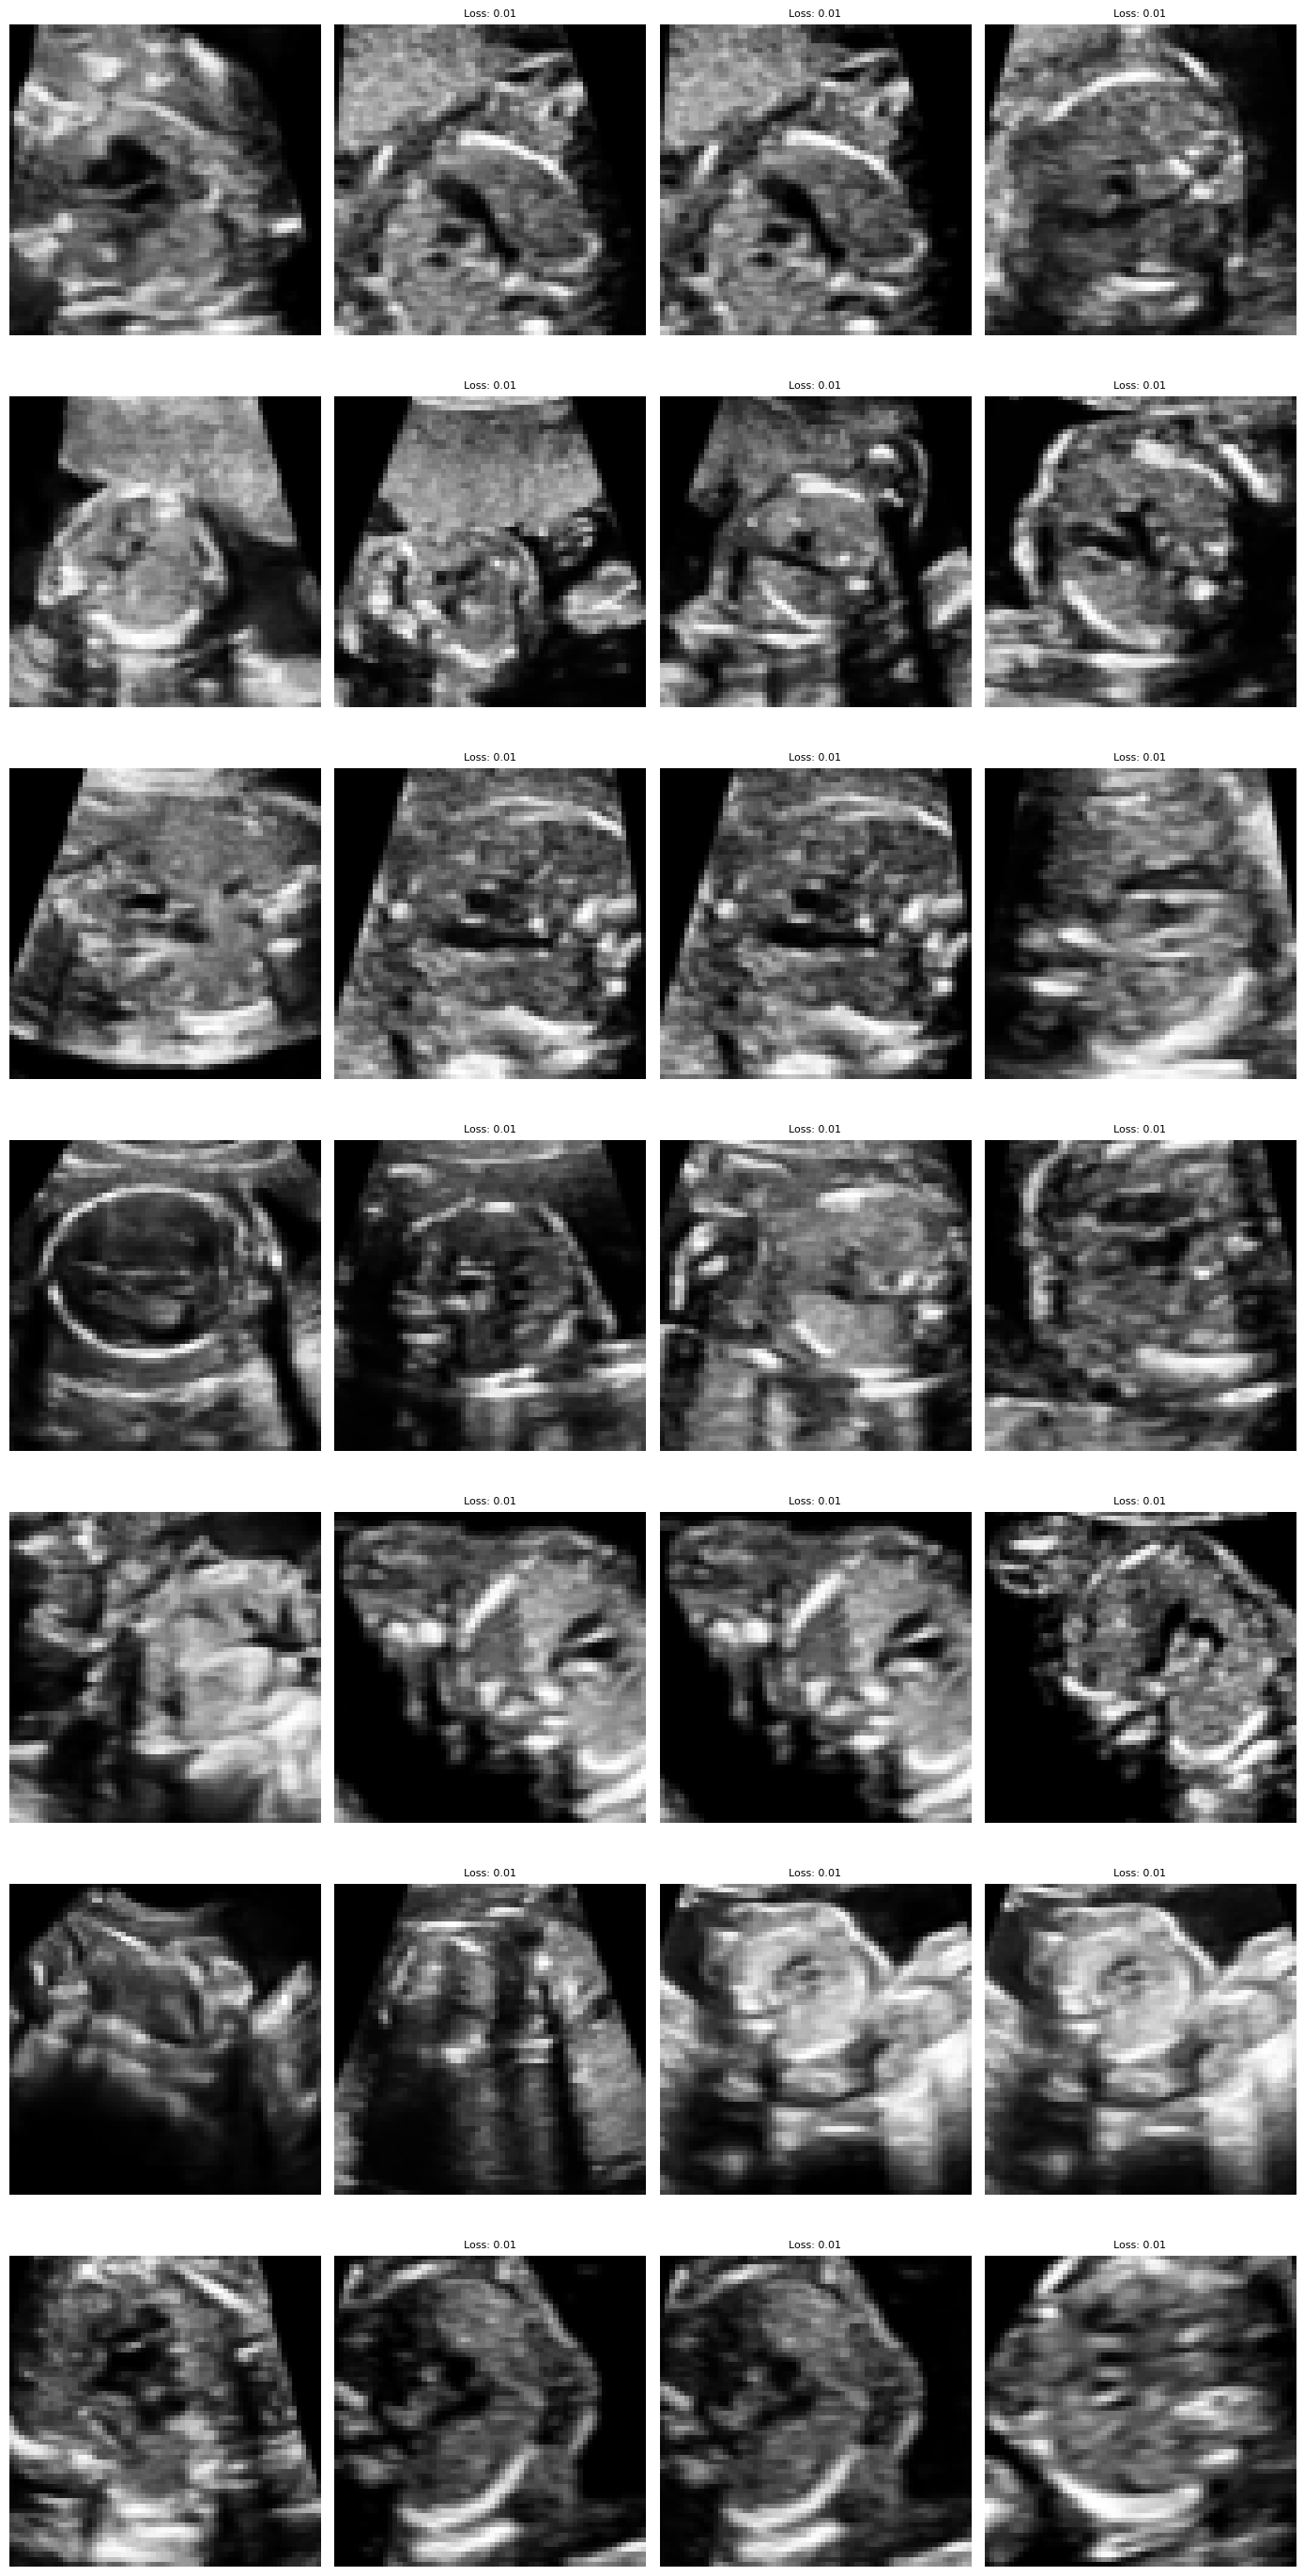

In [29]:
top_k = 3
num_img = 7

for c in range(num_classes):
    all_img_top_k_list = []
    similarity_loss_list = []
    for latent_idx in range(num_img):

        k = (c, latent_idx)
        mse_val_list = sorted(mse_latent_dict[k])[:top_k]
        top_img_idx = [e[1] for e in mse_val_list]
        similarity_loss = [e[0] for e in mse_val_list]
        top_imgs = images_all[top_img_idx].detach().cpu()
        if args.use_sample_ratio:
            latent = torch.unsqueeze(tensor_split[c][latent_idx], 0).detach().cpu()
        else:
            latent = torch.unsqueeze(latents_tmp[(c, latent_idx)], 0).detach().cpu()
        if len(latent.shape) == 3:
            latent = torch.unsqueeze(latent, 0)
        # print(latent.shape, top_imgs.shape)
        all_img_top_k = torch.cat((latent, top_imgs))
        all_img_top_k_list.append(all_img_top_k)
        similarity_loss_list.append(similarity_loss)
        

    plot_images_with_similarity(all_img_top_k_list, similarity_loss_list, num_img)
    break

# Train Top K Images

In [30]:
args.epoch_eval_train = 500

In [31]:
torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

top_k = 1

print(f" ----- top k: {top_k} ----- ")
top_image_list = []
top_label_list = []

for (c, latent_idx) in tqdm(mse_latent_dict):
    k = (c, latent_idx)
    mse_val_list = sorted(mse_latent_dict[k])[:top_k]
    top_img_idx = [e[1] for e in mse_val_list]
    top_imgs = images_all[top_img_idx]
    top_image_list.append(top_imgs)
    top_label_list += [c]*top_k

top_image_list = torch.cat(top_image_list)
top_label_list = torch.tensor(top_label_list)

 ----- top k: 1 ----- 


 14%|█▍        | 86/618 [00:00<00:00, 859.61it/s]

100%|██████████| 618/618 [00:03<00:00, 197.86it/s]


In [32]:
res_subset_dict = {}

model_eval_list = ["ConvNet"]
eval_pool_dict = get_eval_lrs(args)
for model_eval in model_eval_list:
    args.lr_net = eval_pool_dict[model_eval]
    print(f"model: {model_eval}")
    metric_train_all = []
    metric_test_all = []
    for it_eval in range(args.num_eval):
        torch.cuda.empty_cache()
        gc.collect()
        net = get_network(model_eval, channel, num_classes, im_size, depth=args.depth, width=args.width).to(args.device) # get a random model
        net.train()
        _, metric_train_list, metric_test_list = evaluate_synset(
            it_eval, net, top_image_list, top_label_list, testloader, args, decay="cosine", aug=True
        )
        metric_train_all.append(metric_train_list)
        metric_test_all.append(metric_test_list)
    res_subset_dict[model_eval] = metric_test_all

model: ConvNet


100%|██████████| 500/500 [03:02<00:00,  2.74it/s]


In [33]:
dir = f"../experiment_res/subset_{args.method}" if args.use_gan else f"../experiment_res/subset_{args.method}_no_gan"

if args.use_sample_ratio:
    save_name = f'{args.dataset}_{str(args.sample_ratio).replace(".", "__")}.pkl'
    file_prefix = f'subset_{args.method}_{str(args.sample_ratio).replace(".", "__")}_' if args.use_gan else f'subset_{args.method}_no_gan_{str(args.sample_ratio).replace(".", "__")}_'
else:
    save_name = f'{args.dataset}_{str(args.ipc).replace(".", "__")}.pkl'
    file_prefix = f"subset_{args.method}_" if args.use_gan else f"subset_{args.method}_no_gan_"


save_res_dict_excel(res_subset_dict, test_class_count, dir, file_prefix=file_prefix)

Accuracy avg:0.730670, std:0.003879
